# ***Image Captioning Using Flickr8k Dataset***
## **Anish Gawde, Harshil Mistry**
## **DS5220**

# **1. Introduction**

This notebook demonstrates an image captioning system that combines computer vision and natural language processing to generate descriptive captions for images. The model uses:
- **ResNet50**: A pre-trained CNN for image feature extraction.
- **LSTM**: A decoder for generating captions based on extracted features.


### Importing basic libraries

In [2]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

###Importing the dataset

In [3]:
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:09<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [4]:
# Step 1: Define paths
images_path = os.path.join(path, "Images")
captions_file = os.path.join(path, "captions.txt")

# Step 2: Load all the captions
def load_captions(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    # Skip the header and process lines
    data = []
    for line in lines[1:]:
        line = line.strip()
        if line:
            image_name, caption = line.split(",", 1)
            data.append({"image": image_name.strip(), "caption": caption.strip()})
    return pd.DataFrame(data)

df = load_captions(captions_file)

In [5]:
# Step 3: Rename images
def rename_images(df, images_path):
    # Generate new names from 1
    unique_images = df["image"].unique()
    new_names = {original: f"{i+1}.jpg" for i, original in enumerate(unique_images)}

    for old_name, new_name in new_names.items():
        old_path = os.path.join(images_path, old_name)
        new_path = os.path.join(images_path, new_name)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)

    # Update DataFrame
    df["image"] = df["image"].map(new_names)
    return df

df = rename_images(df, images_path)

### Viewing Images with Captions
This step helps visualize the dataset and validate the correspondence between images and their captions.


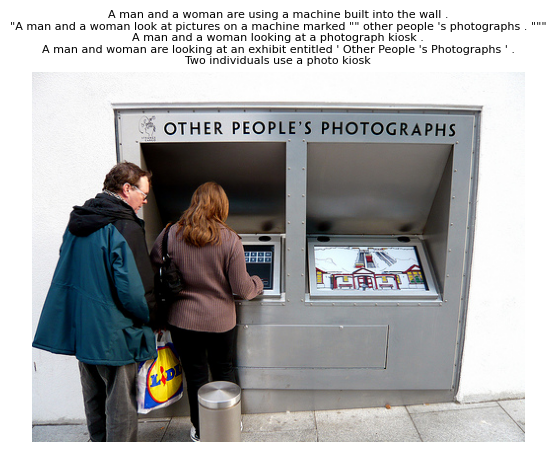

In [6]:
def show_image_with_captions(image_name, df, images_path):
    """Displays an image with all its associated captions."""

    image_path = os.path.join(images_path, image_name)

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

        captions = df[df["image"] == image_name]["caption"].tolist()
        plt.title("\n".join(captions), fontsize=8)  # Display all captions in the title

        plt.show()

    except Exception as e:
        print(f"Error displaying image: {e}")

image = df["image"].iloc[7429]
show_image_with_captions(image, df, images_path)

In [7]:
# Step 4: Save processed data
processed_captions_file = os.path.join(path, "processed_captions.csv")
df.to_csv(processed_captions_file, index=False)
print(f"Processed captions saved to: {processed_captions_file}")

Processed captions saved to: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/processed_captions.csv


In [8]:
df.head(10)

,image,caption
0,1.jpg,A child in a pink dress is climbing up a set o...
1,1.jpg,A girl going into a wooden building .
2,1.jpg,A little girl climbing into a wooden playhouse .
3,1.jpg,A little girl climbing the stairs to her playh...
4,1.jpg,A little girl in a pink dress going into a woo...
5,2.jpg,A black dog and a spotted dog are fighting
6,2.jpg,A black dog and a tri-colored dog playing with...
7,2.jpg,A black dog and a white dog with brown spots a...
8,2.jpg,Two dogs of different breeds looking at each o...
9,2.jpg,Two dogs on pavement moving toward each other .


# **2. Image feature Extraction Using ResNet-50**

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights="imagenet", include_top=True)

# Modify the model to output features from the penultimate layer
model1 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Display the model architecture
model1.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Image Feature Extraction Using ResNet50
ResNet50 is a pre-trained CNN model that extracts high-level visual features from images. These features are used as input to the LSTM decoder for caption generation.

### Preprocessing Images
Images are resized to 224x224, normalized to match the ResNet50 input format, and converted into a format suitable for the model.

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load image with target size for ResNet50
    image = load_img(image_path, target_size=(224, 224))
    # Convert image to numpy array
    image_array = img_to_array(image)
    # Add batch dimension to make it (1, 224, 224, 3) since a ResNet50 model expects input images to have the shape (batch_size, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    # Normalize the image using ResNet50's preprocess_input
    return preprocess_input(image_array)

### Extract the features

In [56]:
# Path to the folder containing images
images_folder = images_path
features_dict = {} # Initialize featres as a dictionary to save all the features

# Extract features for all images
for image_file in os.listdir(images_folder):
    image_path = os.path.join(images_folder, image_file)
    if image_file.endswith((".jpg", ".jpeg", ".png")):  # Check if it's an image file
        # Preprocess and extract features
        input_image = preprocess_image(image_path)
        features = model1.predict(input_image)
        # Organizes the extracted features in a dictionary for easy access and further processing.
        features_dict[image_file] = features

print("Feature extraction complete for all images.")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

### Saving Image features so the model doesn't have to be trained.

In [ ]:
drive_path = '/content/drive/My Drive/image_features.npy'
np.save(drive_path, features_dict)
print(f"Features saved to {drive_path}")

Features saved to /content/drive/My Drive/image_features.npy


In [13]:
drive_path = '/content/drive/My Drive/image_features.npy'
features_dict = np.load(drive_path, allow_pickle=True).item()
print("Features loaded successfully!")

Features loaded successfully!


### Create an image-caption map
Mapping ensures that all captions corresponding to an image are grouped together under a single key.

In [14]:
# Initialize dictionary to store image-captions mapping
image_caption_map = {}

# Use the updated DataFrame 'df' to create the mapping
for index, row in df.iterrows():
    image_name = row['image']  # Use the updated image name from the DataFrame
    caption_text = row['caption']

    # Add the caption to the corresponding image key
    if image_name not in image_caption_map:
        image_caption_map[image_name] = []
    image_caption_map[image_name].append(caption_text.strip())

print("Image-to-captions mapping has been successfully created.")

Image-to-captions mapping has been successfully created.


In [15]:
image_caption_map['1.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Cleaning the captions

In [16]:
import re

def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()

    # Remove special characters and numbers
    caption = re.sub(r'[^a-zA-Z\s]', '', caption)

    # Remove extra whitespaces
    caption = re.sub(r'\s+', ' ', caption).strip()

    # Add start and end sequences
    caption = 'startseq ' + caption + ' endseq'

    return caption


# Clean captions in the image_caption_map
for image_name, captions in image_caption_map.items():
    cleaned_captions = []
    for caption in captions:
        cleaned_captions.append(clean_caption(caption))
    image_caption_map[image_name] = cleaned_captions

image_caption_map['1.jpg']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [17]:
# Initialize a list to store all captions
all_captions = []

# Iterate over the image_caption_map dictionary
for image_name, captions in image_caption_map.items():
    # Add each caption to the all_captions list
    for caption in captions:
        all_captions.append(caption)

# Check the total number of captions
print(f"Total number of captions: {len(all_captions)}")

Total number of captions: 40455


In [18]:
all_captions[:5]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

# **3. Text Generation Using LSTM**

### Tokenizing Captions
Tokenization converts words into numerical representations, which are used by the model during training. The tokenizer is fit on all captions, and the vocabulary size and maximum caption length are determined.


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on all captions
tokenizer.fit_on_texts(all_captions)

# Vocabulary size (add 1 for padding token)
vocab_size = len(tokenizer.word_index) + 1

# Print the vocabulary size
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8781


In [20]:
# Determine the maximum length of captions
max_length = max(len(caption.split()) for caption in all_captions)

# Print the maximum sequence length
print(f"Maximum caption length: {max_length}")

Maximum caption length: 37


In [21]:
# Prepare a list of image IDs
image_ids = list(image_caption_map.keys())

print(f"Image IDs: {image_ids}")

Image IDs: ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jp

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(image_ids, caption_mapping, image_features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize lists to hold batch data
    image_batch, text_batch, target_batch = [], [], []
    batch_count = 0  # Tracks the number of samples in the current batch

    while True:  # Infinite loop for continuous data generation
        for image_id in image_ids:
            # Get the captions for the current image
            captions = caption_mapping[image_id]

            for caption in captions:
                # Convert caption to a sequence of word indices
                sequence = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs for each word in the sequence
                for i in range(1, len(sequence)):
                    # Input sequence up to the current word
                    input_seq = sequence[:i]
                    # Target word (the next word in the sequence)
                    target_word = sequence[i]

                    # Pad the input sequence to the maximum length
                    input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')[0]

                    # One-hot encode the target word
                    target_word_one_hot_encode = to_categorical([target_word], num_classes=vocab_size)[0]

                    # Append data to the batch
                    image_batch.append(image_features[image_id][0])  # Image features
                    text_batch.append(input_seq)  # Input text sequence
                    target_batch.append(target_word_one_hot_encode)  # One-hot encoded target word

            # Yield the batch when it reaches the specified size
            batch_count += 1
            if batch_count == batch_size:
                yield (
                    {"image": np.array(image_batch), "text": np.array(text_batch)},
                    np.array(target_batch),
                )
                # Reset batch data
                image_batch, text_batch, target_batch = [], [], []
                batch_count = 0

In [24]:
from tensorflow.keras.layers import (
    Input, BatchNormalization, Dense, RepeatVector, Embedding, Bidirectional, LSTM,
    Dot, Activation, Concatenate, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

# Image feature input
image_input = Input(shape=(2048,), name="image")  # The input size (2048,) matches the size of the feature vector from ResNet50
image_features = BatchNormalization()(image_input)  # Normalize the image features to make the training process smoother and faster
image_dense = Dense(
    512,
    activation="relu",
    kernel_regularizer=l2(1e-4)  # L2 regularization to this Dense layer as it helps prevent overfitting
)(image_features)
image_repeated = RepeatVector(max_length)(image_dense)  # Repeat features for sequence alignment

# Text sequence input
# Each caption is tokenized and padded to have the same maximum length
text_input = Input(shape=(max_length,), name="text")  # Input for text sequences
text_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(text_input)  # These embeddings help the model understand the relationships between words
text_normalized = BatchNormalization()(text_embedding)  # Normalize embeddings
# Use a bidirectional LSTM to process the caption sequence
# This captures relationships in both forward and backward directions,
# which helps the model understand context better when generating captions.
text_lstm = Bidirectional(LSTM(256, return_sequences=True))(text_normalized)\

# Attention mechanism
# Calculate how much attention each word in the caption should pay to different parts of the image
attention_scores = Dot(axes=[2, 2])([image_repeated, text_lstm])
attention_normal = Activation("softmax")(attention_scores)  # Normalize scores to get attention weights
context_vector = Dot(axes=[1, 1])([attention_normal, text_lstm])  # Weighted sum for context vector
context_vector = BatchNormalization()(context_vector)  # Normalize context vector

# Decoder
context_flat = Flatten()(context_vector)  # Flatten context vector
combined_features = Concatenate()([context_flat, image_dense])  # Combine the processed image features and the context vector into a single input
# This merges visual and textual information for the decoder
hidden_decoder = Dense(512, activation="relu")(combined_features)  # Dense layer for decoding
output_layer = Dense(vocab_size, activation="softmax")(hidden_decoder)  # Final output layer

# Define the model
model = Model(inputs=[image_input, text_input], outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)  # Use optimizer with gradient clipping
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [26]:
# Define training parameters
epochs = 20
batch_size = 32
steps_per_epoch = len(image_ids) // batch_size

# Train the model
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Create a new generator for each epoch
    train_generator = data_generator(
        image_ids,  # Pass image_ids directly as the first positional argument
        image_caption_map, # Changed 'mapping' to 'image_caption_map'
        features_dict,  # Changed 'features' to 'features_dict'
        tokenizer,
        max_length,
        vocab_size,
        batch_size
    )

    # Train for one epoch
    model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    history = model.history.history
    print("Loss:", history['loss'][-1])
    print("Accuracy:", history['accuracy'][-1])

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 86s 340ms/step - accuracy: 0.5589 - loss: 1.7663
Loss: 1.724927544593811
Accuracy: 0.5675764679908752
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - accuracy: 0.5951 - loss: 1.5905
Loss: 1.559212327003479
Accuracy: 0.6024216413497925
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 332ms/step - accuracy: 0.6254 - loss: 1.4530
Loss: 1.4264016151428223
Accuracy: 0.631496787071228
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 332ms/step - accuracy: 0.6538 - loss: 1.3284
Loss: 1.3086425065994263
Accuracy: 0.6588506102561951
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 83s 329ms/step - accuracy: 0.6769 - loss: 1.2319
Loss: 1.208701252937317
Accuracy: 0.6825997233390808
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 334ms/step - accuracy: 0.6937 - loss: 1.1566
Loss: 1.136196255683899
Accuracy: 0.6986724138259888
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 85s 339ms/step - accuracy: 0.7121 - loss: 1.0778
Loss: 1.0657564401626587
Accuracy: 0.7147976756095886
Epoc

In [53]:
model.save('/content/drive/MyDrive/image_captioning_model_1.keras')
model.save_weights('/content/drive/MyDrive/image_captioning_model_weights.weights.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/image_captioning_model.keras')

In [27]:
def generate_caption(model, tokenizer, image_feature, max_length):
    """
    Generate a caption for a given image feature using the trained model.
    """
    # Start the caption generation with the <startseq> token
    input_text = "startseq"

    # Iterate until the maximum caption length
    for _ in range(max_length):
        # Convert the input text to a sequence of integers
        sequence = tokenizer.texts_to_sequences([input_text])[0]

        # Pad the sequence to the maximum length
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post")

        # Predict the next word
        y_pred = model.predict([image_feature, sequence], verbose=0)
        next_word_idx = np.argmax(y_pred)  # Get the index of the predicted word

        # Convert the index to the corresponding word
        next_word = tokenizer.index_word.get(next_word_idx, None)

        # Break if no word is found or <endseq> is generated
        if next_word is None or next_word == "endseq":
            break

        # Append the predicted word to the input text
        input_text += " " + next_word

    # Remove the <startseq> token and return the generated caption
    return input_text.replace("startseq", "").strip()

In [28]:
image_feature = features_dict['750.jpg']  # Get the feature from features_dict
image_feature = image_feature.reshape(1, -1)
generated_caption = generate_caption(model, tokenizer, image_feature, max_length)
print(f"Generated caption: {generated_caption}")

Generated caption: a girl in a red devil costume in front of a fountain


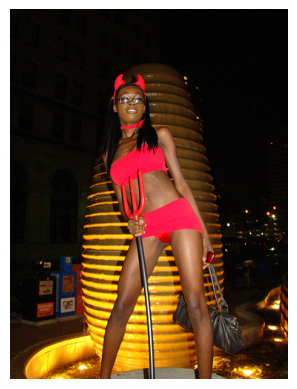

In [29]:
image_path = os.path.join(images_path, '750.jpg')

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [30]:
image_caption_map['750.jpg']

['startseq a girl dressed as a devil stands in front of a lighted object on a city street endseq',
 'startseq a girl is dressed up in a red devil outfit endseq',
 'startseq a woman in a devil outfit standing in front of a fountain endseq',
 'startseq a woman in a red devil costume in front of a fountain endseq',
 'startseq a woman wears a devil costume and poses in front of a fountain endseq']

## **4. Analysing the generated captions**

In [31]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def calculate_bleu_score_dynamically(image_id, image_caption_map, generated_caption):
    """
    Calculate the BLEU score for a generated caption by dynamically fetching reference captions.
    """
    # Fetch ground truth captions for the given image ID
    if image_id not in image_caption_map:
        print(f"No captions found for image {image_id}.")
        return None

    reference_captions = image_caption_map[image_id]

    # Tokenize captions
    references = [caption.split() for caption in reference_captions]  # Tokenized ground truth captions
    candidate = generated_caption.split()  # Tokenized generated caption
 # Apply smoothing
    smooth_fn = SmoothingFunction().method2

    # Calculate BLEU score
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smooth_fn)
    return bleu_score

In [32]:
image_id = "750.jpg"
# Calculate BLEU score
bleu_score = calculate_bleu_score_dynamically(image_id, image_caption_map, generated_caption)
if bleu_score is not None:
    print(f"BLEU score for image {image_id}: {bleu_score:.4f}")

BLEU score for image 750.jpg: 0.8801


# **5. Custom Image caption generation**

In [46]:
image_path = "/content/drive/MyDrive/IMG_0631.jpg"

In [34]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess a custom image for feature extraction.
    """
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize for ResNet50
    return img_array

In [35]:
def extract_features(image_array, feature_extractor):
    """
    Extract features from the custom image using a pre-trained encoder.
    """
    features = feature_extractor.predict(image_array)
    return features.reshape(1, -1)  # Ensure the shape matches (1, 2048)

In [36]:
def generate_caption1(model, tokenizer, image_feature, max_length):
    """
    Generate a caption for a given image feature using the trained model.
    """
    input_text = "startseq"

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post")  # Pad the sequence

        # Predict the next word
        y_pred = model.predict([image_feature, sequence], verbose=0)
        next_word_idx = np.argmax(y_pred)
        next_word = tokenizer.index_word.get(next_word_idx, None)

        if not next_word or next_word == "endseq":  # Stop if end token or no word
            break

        input_text += " " + next_word

    return input_text.replace("startseq", "").strip()

In [37]:
def caption_custom_image(image_path, model, tokenizer, max_length):
    """
    Generate a caption for a custom image.
    """
    # Load the pre-trained feature extractor (e.g., ResNet50)
    feature_extractor = ResNet50(weights="imagenet", include_top=False, pooling="avg")

    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Extract image features
    image_feature = extract_features(image_array, feature_extractor)

    # Generate caption
    caption = generate_caption1(model, tokenizer, image_feature, max_length)

    return caption

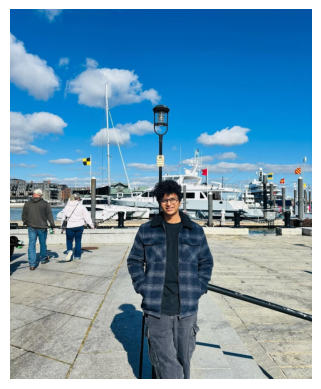

In [44]:
img = mpimg.imread('/content/drive/MyDrive/IMG_0631.jpg')
plt.imshow(img)
plt.axis('off') # Hide the axis
plt.show()

In [47]:
generated_caption = caption_custom_image(image_path, model, tokenizer, max_length)
print("Generated Caption:", generated_caption)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Generated Caption: a boy stands on a beach with a sunset in the background


In [51]:
image_path = "/content/drive/MyDrive/IMG_0635.JPG"

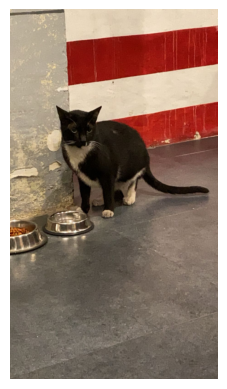

In [50]:
img = mpimg.imread('/content/drive/MyDrive/IMG_0635.JPG')
plt.imshow(img)
plt.axis('off') # Hide the axis
plt.show()

In [52]:
generated_caption = caption_custom_image(image_path, model, tokenizer, max_length)
print("Generated Caption:", generated_caption)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Generated Caption: a black and white dog is digging in a backyard room with a large black container
